# Imports

In [96]:
# Import all libraries
import requests
from tqdm import trange
import zipfile
import os
from PIL import Image
import numpy as np
import pylab as plt
import matplotlib
from random import randint
from scipy.ndimage.interpolation import rotate
from skimage.transform import rescale, resize
from IPython.display import clear_output
import random
import shutil
%matplotlib inline

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization
from keras import optimizers, regularizers
from keras.optimizers import SGD, Adam
import keras.callbacks
from keras import backend as K

import h5py
from keras.utils.np_utils import to_categorical



from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from sklearn.metrics import accuracy_score



# this part is needed if you run the notebook on Cartesius with multiple cores
n_cores = 32
config = tf.ConfigProto(intra_op_parallelism_threads=n_cores-1, inter_op_parallelism_threads=1, allow_soft_placement=True)
session = tf.Session(config=config)
K.set_session(session)
os.environ["OMP_NUM_THREADS"] = str(n_cores-1)
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

# Classes

In [3]:
class DataSet:
    
    def __init__(self, data_dir_x, data_dir_y = None):
        self.data_dir_x = data_dir_x
        self.data_dir_y = data_dir_y
    
    def get_lenght(self):
        with h5py.File(self.data_dir_x, 'r') as hdf:
            return len(hdf['x'])
    
    def show_image(self, i):
        with h5py.File(self.data_dir_x, 'r') as hdf:
            data = list(hdf['x'][i])
            img = np.array(data)
            plt.imshow(img)
            plt.title('RGB image')
            plt.show()

        

In [79]:
class BatchCreator:
    
    def __init__(self, dataset):
        self.dataset = dataset
        self.dataset_length = self.dataset.get_lenght()
        


    def create_batch(self, batch_size):
        start_pos = np.random.randint(0,self.dataset_length-batch_size+1)
        x_data = np.array([])
        y_data = np.array([])
      
        with h5py.File(self.dataset.data_dir_x, 'r') as hdf:
            data = list(hdf['x'][start_pos:start_pos+batch_size])
            
            
            x_data = np.array(data)
        
        with h5py.File(self.dataset.data_dir_y, 'r') as hdf:
            data = list(hdf['y'][start_pos:start_pos+batch_size])
            data = np.reshape(data,(batch_size,1))
            data = to_categorical(data, num_classes=2)
            y_data = np.array(data)  
            
            
        return x_data, y_data
    

        
    def get_generator(self, batch_size):
        '''returns a generator that will yield batches infinitely'''
        while True:
            yield self.create_batch(batch_size)

In [105]:
def calculate_dice(x, y):
    '''returns the dice similarity score, between two boolean arrays'''
    return 2 * np.count_nonzero(x & y) / (np.count_nonzero(x) + np.count_nonzero(y))

class Logger(keras.callbacks.Callback):

    def __init__(self, validation_data, saving_dir, model_name, validation_batch_size):
        
        self.validation_dataset = validation_data
        self.validtaion_dataset_length = self.validation_dataset.get_lenght()
        self.validation_batch_creator = BatchCreator(self.validation_dataset)
        
        #take 0-100% of the validatin dataset for validation
        self.val_imgs, self.val_lbls = self.validation_batch_creator.create_batch(int(self.validtaion_dataset_length*validation_batch_size))
    
        self.model_filename = os.path.join(saving_dir, model_name + '.h5')
        
        self.losses = []
        self.accurancies = []
        self.best_validation_acc = 0
        self.best_model = None
        self.predictions = None
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.losses.append(logs.get('acc'))
    
    def on_epoch_end(self, batch, logs={}):
        acc = self.validate()
        self.accurancies.append([len(self.losses), acc])
        if acc > self.best_validation_acc:
            self.best_validation_acc = acc
            self.model.save(self.model_filename) # save best model to disk
            print('best model saved as {}'.format(self.model_filename))
        self.plot()   
    
    def validate(self):
        predicted_lbls = to_categorical(np.argmax(self.model.predict(self.val_imgs, batch_size=1), axis=1), num_classes=2)
        return accuracy_score(self.val_lbls, predicted_lbls)

    
    def plot(self):
        clear_output()
        N = len(self.losses)
        plt.figure(figsize=(50, 10))
        plt.subplot(1, 2, 1)
        plt.plot(range(0, N), self.losses); plt.title('losses')
        plt.subplot(1, 2, 2)
        plt.plot(*np.array(self.accurancies).T); plt.title('accurancies')
        plt.show
   

# Load Data

In [106]:
#data dirs
data_dir = './data/'
train_dir_x = os.path.join(data_dir, 'camelyonpatch_level_2_split_train_x.h5')
train_dir_y = os.path.join(data_dir, 'camelyonpatch_level_2_split_train_y.h5')
valid_dir_x = os.path.join(data_dir, 'camelyonpatch_level_2_split_valid_x.h5')
valid_dir_y = os.path.join(data_dir, 'camelyonpatch_level_2_split_valid_y.h5')
test_dir_x = os.path.join(data_dir, 'camelyonpatch_level_2_split_test_x.h5')

print(train_dir_x)

./data/camelyonpatch_level_2_split_train_x.h5


262144


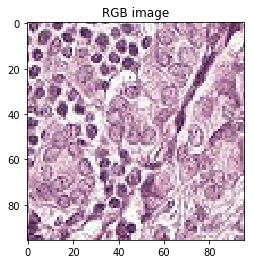

In [107]:
training_dataset = DataSet(train_dir_x, train_dir_y)
validation_dataset = DataSet(valid_dir_x, valid_dir_y)
test_dataset = DataSet(test_dir_x)
print(training_dataset.get_lenght())
training_dataset.show_image(1)


In [108]:
#test batch creator
batch_creator = BatchCreator(validation_dataset)
batch = batch_creator.create_batch(100)
print(batch[0].shape)
print(batch[1].shape)

(100, 96, 96, 3)
(100, 2)


# Create Model


In [109]:
def build_model(printmodel=False):
    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128

    dropout_conv = 0.3
    dropout_dense = 0.5

    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
    model.add(Conv2D(first_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(256, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(2, activation = "softmax"))
    
    if printmodel:
        print(model.summary())
    
    return model


In [110]:
model = build_model(True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_67 (Batc (None, 92, 92, 32)        128       
_________________________________________________________________
activation_67 (Activation)   (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 44, 44, 64)        18432     
__________

# Train Model

In [111]:
def train_model(model, training_params):
    
    batch_size = training_params['batch_size']
    loss = training_params['loss']
    metrics = training_params['metrics']
    epochs = training_params['epochs']
    steps_per_epoch = training_params['steps_per_epoch']
    optimizer = training_params['optimizer']
    training_dataset = training_params['training_dataset']
    validation_dataset = training_params['validation_dataset']
    logger = training_params['logger']
    
        
    # batch generator 
    batch_creator = BatchCreator(training_dataset)
    batch_generator = batch_creator.get_generator(batch_size)

    # compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # train the model
    model.fit_generator(generator=batch_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=epochs,
                        callbacks=[logger])

In [ ]:
# training parameters
saving_dir = './models/'
if(not os.path.exists(saving_dir)):
    os.mkdir(saving_dir)

model_name = 'model'
training_params = {}
training_params['learning_rate'] = 1e-3
training_params['batch_size'] = 32 # number of patches in a mini-batch
training_params['steps_per_epoch'] = 1 # number of iterations per epoch
training_params['epochs'] = 10 # number of epochs

training_params['optimizer'] = SGD(lr=training_params['learning_rate'], momentum=0.9, nesterov=True)
training_params['loss'] = ['categorical_crossentropy']
training_params['metrics'] = ['accuracy']
training_params['training_dataset'] = training_dataset
training_params['validation_dataset'] = validation_dataset

training_params['logger'] = Logger(validation_dataset, saving_dir, model_name, 0.001)

# train model
train_model(model, training_params)

Epoch 7/10
